# Clustering With K-Means
## California housing dataset clustering using KMeans

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

df = pd.read_csv("../datasets/housing.csv")

### 找出房屋所在位置(經緯度)和收入中位數是否有群集關係

In [2]:
X = df.loc[:, ["median_income", "latitude", "longitude"]]
X.head()

,median_income,latitude,longitude
0,8.3252,37.88,-122.23
1,8.3014,37.86,-122.22
2,7.2574,37.85,-122.24
3,5.6431,37.85,-122.25
4,3.8462,37.85,-122.25


### 用 k-means 建立群集分類

In [3]:
# Create cluster feature
kmeans = KMeans(n_clusters=6)
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")

X.head()

,median_income,latitude,longitude,Cluster
0,8.3252,37.88,-122.23,1
1,8.3014,37.86,-122.22,1
2,7.2574,37.85,-122.24,1
3,5.6431,37.85,-122.25,1
4,3.8462,37.85,-122.25,4


### 繪製房屋位置與 Cluster 關係圖

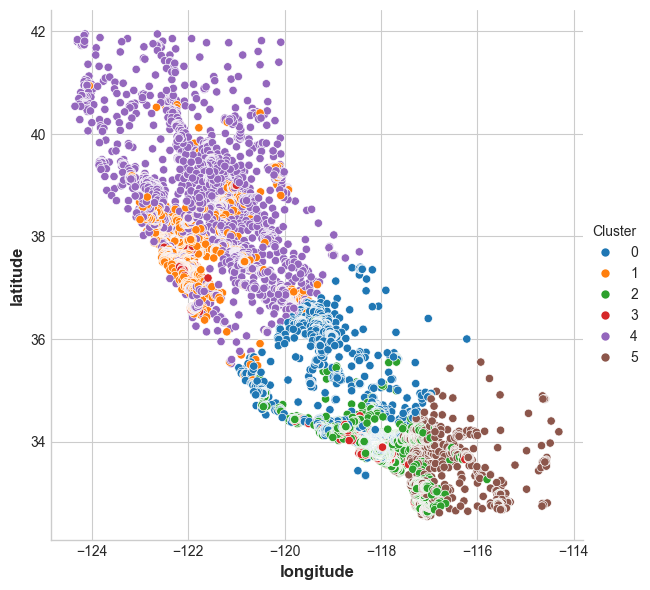

In [4]:
sns.relplot(
    x="longitude", y="latitude", hue="Cluster", data=X, height=6,
)

### median_income 在每個 Cluster 類別的分布

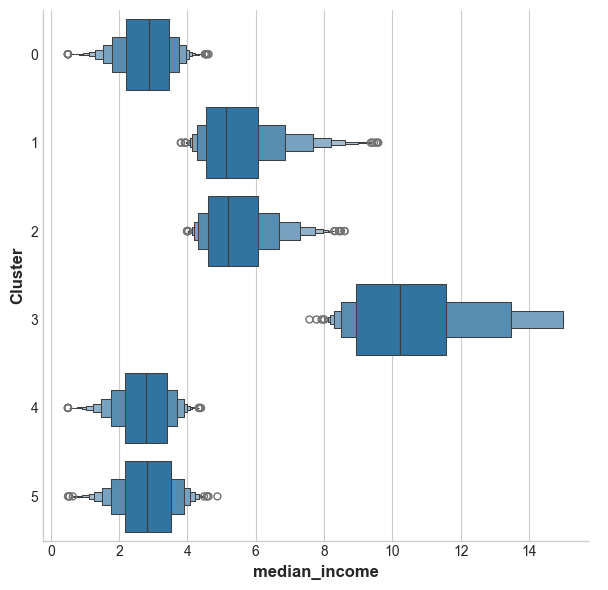

In [6]:
sns.catplot(x="median_income", y="Cluster", data=X, kind="boxen", height=6)

### median_house_value 在每個 Cluster 類別的分布

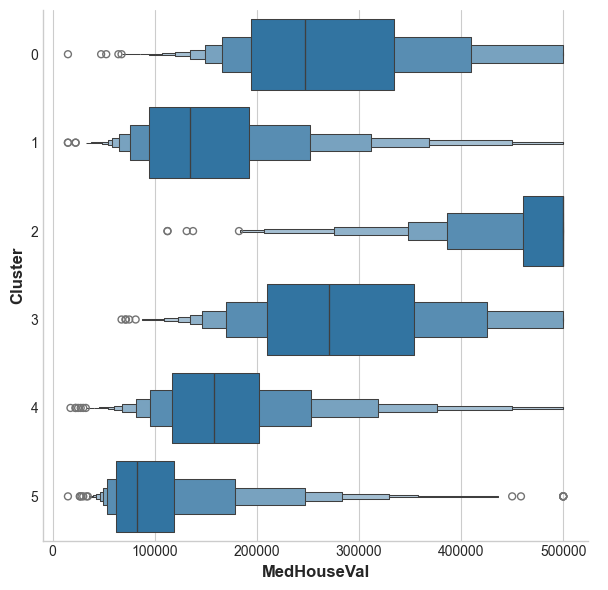

In [5]:
X["MedHouseVal"] = df["median_house_value"]
sns.catplot(x="MedHouseVal", y="Cluster", data=X, kind="boxen", height=6)

## 分群後資料的運用與確認
### 建立 Cross-validation function, 以做為評估資料集中加入分群的效果

In [3]:
def score_dataset(X, y, model=XGBRegressor()):
    """
    Calculates the Root Mean Squared Log Error (RMSLE) for a given dataset and model using cross-validation.

    This function label-encodes categorical features in the input DataFrame `X`, then evaluates the provided regression model
    (default: XGBRegressor) using 5-fold cross-validation. The scoring metric used is negative mean squared log error,
    which is then converted to RMSLE.

    Args:
        X (pd.DataFrame): Feature matrix containing predictors. Categorical columns will be label-encoded.
        y (pd.Series or np.ndarray): Target variable.
        model (sklearn.base.RegressorMixin, optional): Regression model to evaluate. Defaults to XGBRegressor().

    Returns:
        float: The cross-validated RMSLE score for the model on the provided data.

    # Brief: Evaluates a regression model using cross-validated RMSLE after encoding categorical features.
    """
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


# Prepare data
df = pd.read_csv("../datasets/ames.csv")

X = df.copy()
y = X.pop("SalePrice")

### 將房屋各種面積的資訊做分類
* 在做 K-means 之前先對做資料數據做標準化

In [4]:
# Define a list of the features to be used for the clustering
features = ["LotArea", "TotalBsmtSF", "FirstFlrSF", "SecondFlrSF", "GrLivArea"]


# Standardize
X_scaled = X.loc[:, features]
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)

In [5]:
# Fit the KMeans model to X_scaled and create the cluster labels
kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)
X["Cluster"] = kmeans.fit_predict(X_scaled)

np.float64(0.1427869260707135)

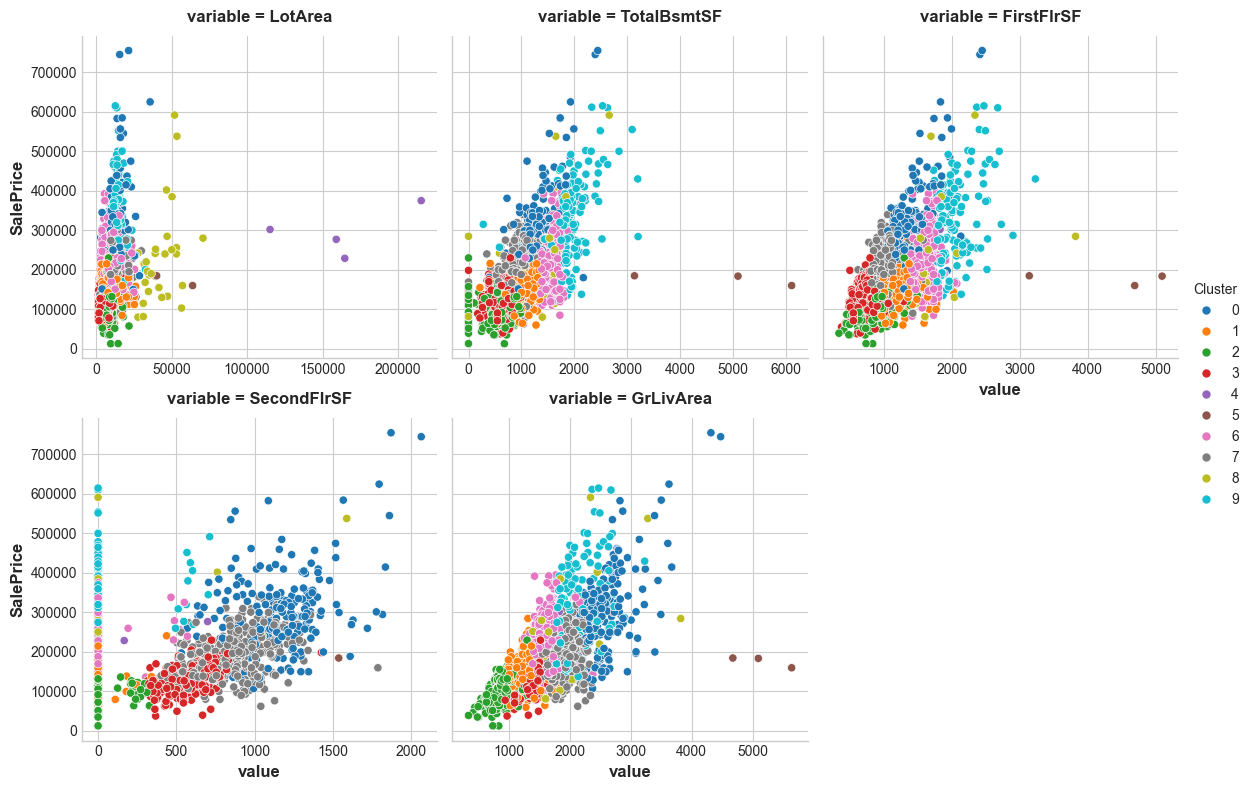

In [6]:
Xy = X.copy()
Xy["Cluster"] = Xy.Cluster.astype("category")
Xy["SalePrice"] = y
sns.relplot(
    x="value", y="SalePrice", hue="Cluster", col="variable",
    height=4, aspect=1, facet_kws={'sharex': False}, col_wrap=3,
    data=Xy.melt(
        value_vars=features, id_vars=["SalePrice", "Cluster"],
    ),
)

score_dataset(X, y)

### 用 kmeans.fit_transform() 可以產生每筆資料對每個類別質心 (centroid) 的距離數據

In [7]:
kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)

# Create the cluster-distance features using `fit_transform`
X_cd = kmeans.fit_transform(X_scaled)

# Label features and join to dataset
X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
X = X.join(X_cd)

X_cd.head()

score_dataset(X, y)

np.float64(0.13740474194546512)

In [8]:
print(X_cd.head())

   Centroid_0  Centroid_1  Centroid_2  Centroid_3  Centroid_4  Centroid_5  \
0    4.134181    3.236678    3.977023    4.316398   16.792665   13.097627   
1    4.615628    1.075352    0.621685    1.885029   19.594509   15.785445   
2    3.707220    0.953832    2.157567    2.713650   19.030448   14.058973   
3    3.874506    3.792481    5.085077    5.236814   19.392116   11.373003   
4    2.651716    2.070336    2.337714    1.306043   19.225117   14.749591   

   Centroid_6  Centroid_7  Centroid_8  Centroid_9  
0    2.870851    3.789935    1.604330    3.315926  
1    2.575580    2.745164    4.932333    4.508933  
2    0.975653    2.618381    3.927018    2.780135  
3    2.243512    4.444882    4.673607    0.508460  
4    2.660527    0.733775    4.390193    4.103626  
